In [8]:
import cv2
import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from scipy.interpolate import UnivariateSpline
from scipy.signal import find_peaks_cwt
% matplotlib inline

In [9]:
data = pickle.load(open ("camera_calibration.pkl", "rb"))
mtx_camera = data[0]
dist_camera = data[1]

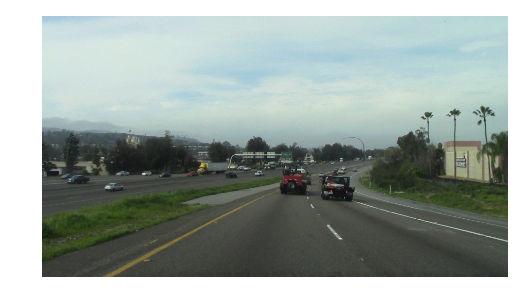

In [10]:
image = mpimg.imread('test_images/test_1.jpg')
image = cv2.resize(image,(960,540))
plt.imshow(image);
plt.axis('off');

In [29]:
kernel_size = 5

def draw_pw_lines(img, pts, color):
    pts = np.int_(pts)
    for i in range (10):
        x1 = pts[0][i][0]
        y1 = pts[0][i][1]
        x2 = pts[0][i+1][0]
        y2 = pts[0][i+1][1]
        cv2.line(img, (x1,y1), (x2,y2), color, 50)
        
def undistort_image(img, mtx, dist):
    undist_img = cv2.undistort(img,mtx, dist, None, mtx)
    return undist_img

def gaussian_blur(img, kernel=5):
    blur = cv2.GaussianBlur(img, (kernel, kernel),0)
    return blur

def abs_sobel_thresh(img, orient ='x', sobel_kernel = 3, thresh=(0,255)):
    if orient == 'x':
        img_s = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    else:
        img_s = cv2.Sobel(img, cv2.CV_64F, 0, 1)
    img_abs = np.absolute(img_s)
    img_sobel = np.uint8(255*img_abs/np.max(img_abs))
    
    binary_output = 0*img_sobel
    binary_output[(img_sobel >= thresh[0])& (img_sobel <= thresh[1])] =1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    img_sx = cv2.Sobel(img,cv2.CV_64F,1,0, ksize=sobel_kernel)
    img_sy = cv2.Sobel(img,cv2.CV_64F,0,1, ksize=sobel_kernel)
    
    grad_s = np.arctan2(np.absolute(img_sy), np.absolute(img_sx))
    
    binary_output = 0*grad_s # Remove this line
    binary_output[(grad_s>=thresh[0]) & (grad_s<=thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0,255)):
    img_sx = cv2.Sobel(img, cv2.CV_64F, 1, 0)
    img_sy = cv2.Sobel(img,cv2.CV_64F, 0, 1)
    img_s = np.sqrt(img_sx**2 + img_sy**2)
    img_s = np.uint8(img_s*255/np.max(img_s))
    binary_output = 0*img_s
    binary_output[(img_s >= thresh[0])& (img_s <= thresh[1])] =1
    return binary_output

def GaussianC_Adaptive_Threshold(img,kernel,cut_val):
    img_cut = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,kernel, cut_val)
    return img_cut

def warp_image(img, src, dst, img_size):
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, img_size, flags= cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return warped, M, Minv

def sobel_combined(image):
    img_g_mag = mag_thresh(image, 3,(20,150))
    img_d_mag = dir_threshold(image,3,(.6,1.1))
    img_abs_x = abs_sobel_thresh(image, 'x',5,(50,200))
    img_abs_y = abs_sobel_thresh(image, 'y',5,(50,200))
    sobel_combined = np.zeros_like(img_d_mag)
    sobel_combined[((img_abs_x ==1)&(img_abs_y == 1)) | ((img_g_mag ==1)&(img_d_mag ==1))] =1
    return sobel_combined

def color_mask (hsv, low, high):
    mask = cv2.inRange(hsv, low, high)
    return mask

def apply_color_mask(hsv, img, low, high):
    mask = cv2.inRange(hsv, low, high)
    res = cv2.bitwise_and(img, img, mask = mask)
    return res

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n-1:]/n

In [13]:
image_ud = undistort_image(image, mtx_camera , dist_camera )

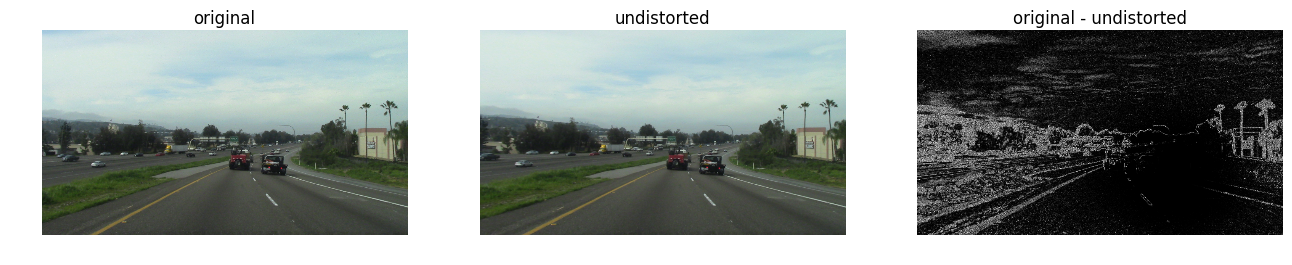

In [14]:
plt.figure(figsize=(16,9))
plt.subplot(1,3,1)
plt.imshow(image)
plt.axis('off');
plt.title('original')
plt.subplot(1,3,2)
plt.imshow(image_ud)
plt.title('undistorted')
plt.axis('off');
plt.subplot(1,3,3)
plt.imshow(np.sum((image-image_ud)**2,axis=2),cmap='gray')
plt.title('original - undistorted')
plt.axis('off');

In [15]:
image = image_ud
img_size = np.shape(image)

In [16]:
ht_window = np.uint(img_size[0]/1.5)
hb_window = np.uint(img_size[0])
c_window = np.uint(img_size[1]/2)
ctl_window = c_window - 0.2*np.uint(img_size[1]/2)
ctr_window = c_window + 0.2*np.uint(img_size[1]/2)
cbl_window = c_window - 0.9*np.uint(img_size[1]/2)
cbr_window = c_window + 0.9*np.uint(img_size[1]/2)

src = np.float32([[cbl_window,hb_window],[cbr_window,hb_window],[ctr_window,ht_window],[ctl_window,ht_window]])

dst = np.float32([[0,img_size[0]],[img_size[1],img_size[0]],
                  [img_size[1],0],[0,0]])

warped,M_warp,Minv_warp = warp_image(image,src,dst,(img_size[1],img_size[0]))

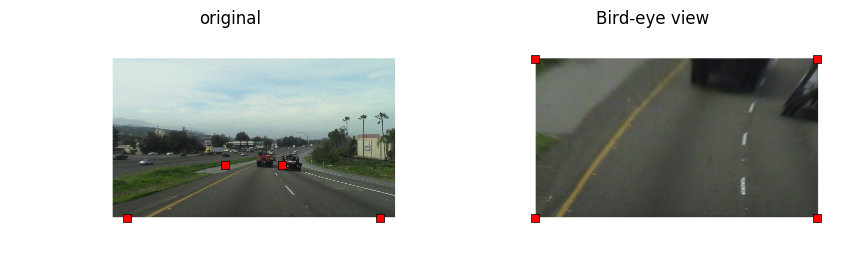

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(image,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(warped,cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
    
plt.title('Bird-eye view')
plt.axis('off');

In [18]:
image_HSV = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)

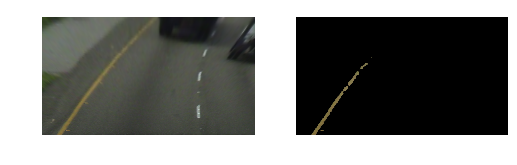

In [19]:
yellow_hsv_low = np.array([0,100,100])
yellow_hsv_high = np.array([80, 255, 255])

res_mask =color_mask(image_HSV, yellow_hsv_low,yellow_hsv_high)
res = apply_color_mask(image_HSV,warped,yellow_hsv_low,yellow_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res)
plt.axis('off');

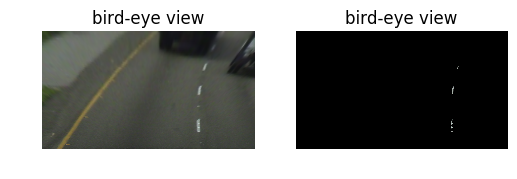

In [20]:
image_HSV = cv2.cvtColor(warped,cv2.COLOR_RGB2HSV)


white_hsv_low  = np.array([ 0,   0,   160])
white_hsv_high = np.array([ 255,  80, 255])

res1 = apply_color_mask(image_HSV,warped,white_hsv_low,white_hsv_high)

plt.subplot(1,2,1)
plt.imshow(warped)
plt.title('bird-eye view')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(res1)
plt.title('bird-eye view')
plt.axis('off');

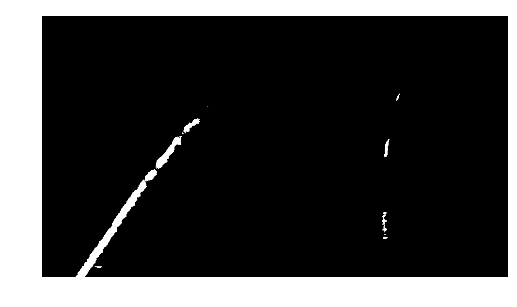

In [21]:
mask_yellow = color_mask(image_HSV, yellow_hsv_low, yellow_hsv_high)
mask_white = color_mask(image_HSV, white_hsv_low, white_hsv_high)
mask_lane = cv2.bitwise_or(mask_yellow, mask_white)
plt.imshow(mask_lane, cmap='gray')
plt.axis('off');

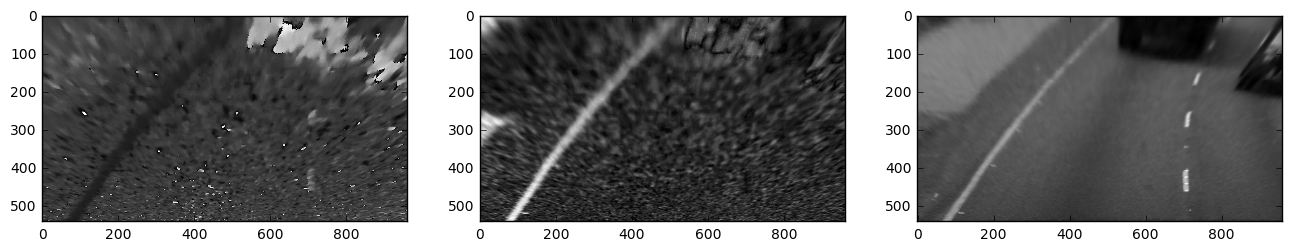

In [23]:
plt.figure(figsize=[16, 9])
plt.subplot(1,3,1)
plt.imshow(image_HSV[:,:,0],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(image_HSV[:,:,1],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(image_HSV[:,:,2],cmap='gray')

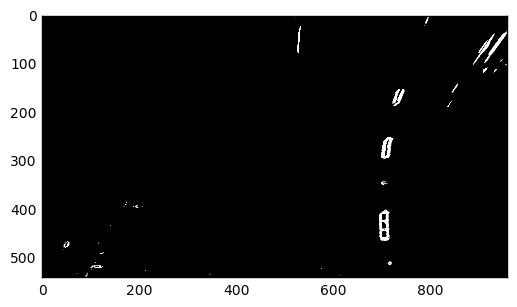

In [30]:
image = gaussian_blur(warped, kernel=5)
image_HLS = cv2.cvtColor(warped,cv2.COLOR_RGB2HLS)
img_gs = image_HLS[:,:,1]
sobel_c = sobel_combined(img_gs)
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped2 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

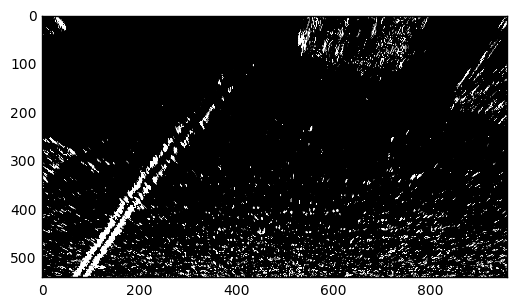

In [31]:
img_gs = image_HLS[:,:,2]
sobel_c = sobel_combined(img_gs)
img_abs_x = abs_sobel_thresh(img_gs,'x',5,(50,225))
img_abs_y = abs_sobel_thresh(img_gs,'y',5,(50,225))
plt.imshow(cv2.bitwise_or(img_abs_x,img_abs_y),cmap='gray')

wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))

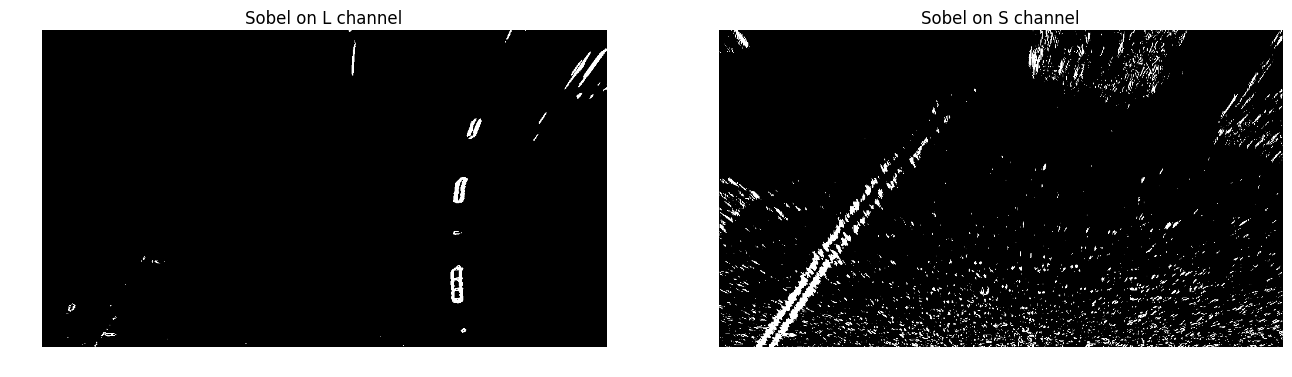

In [32]:
wraped3 = np.copy(cv2.bitwise_or(img_abs_x,img_abs_y))
plt.figure(figsize=[16, 9])
plt.subplot(1,2,1)
plt.imshow(wraped2,cmap='gray')
plt.title('Sobel on L channel')
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Sobel on S channel')
plt.imshow(wraped3,cmap='gray')
plt.axis('off');

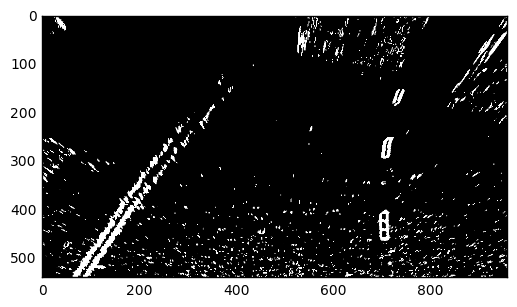

In [33]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb = gaussian_blur(image_cmb,3)
plt.imshow(image_cmb,cmap='gray')

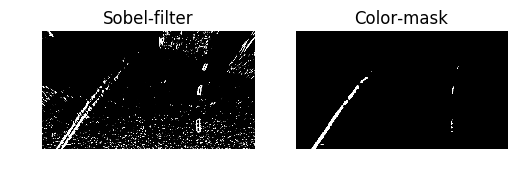

In [34]:
image_cmb = cv2.bitwise_or(wraped2,wraped3)
image_cmb1 = np.zeros_like(image_cmb)
image_cmb1[(mask_lane>=.5)|(image_cmb>=.5)]=1


plt.subplot(1,2,1)
plt.imshow(image_cmb,cmap='gray')
plt.axis('off')
plt.title('Sobel-filter')
plt.subplot(1,2,2)
plt.imshow(mask_lane,cmap='gray')
plt.axis('off')
plt.title('Color-mask')

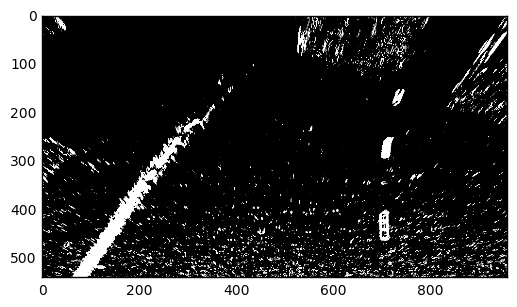

In [35]:
plt.imshow(gaussian_blur(image_cmb1,1),cmap='gray')

/Users/Anonymous/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/Anonymous/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:83: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Anonymous/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:84: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Anonymous/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 960)

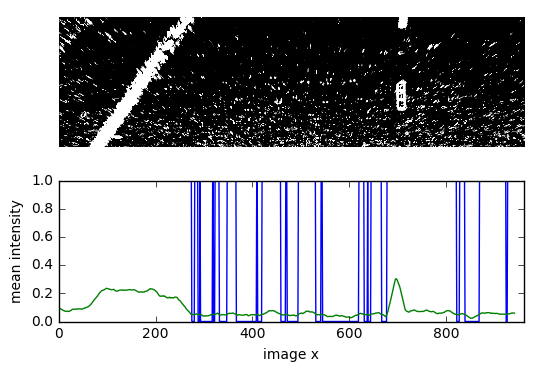

In [36]:
mov_filtsize = img_size[1]/50.
mean_lane = np.mean(image_cmb1[img_size[0]/2:,:],axis=0)
mean_lane = moving_average(mean_lane,mov_filtsize)


plt.subplot(2,1,1)
plt.imshow(image_cmb1[img_size[0]/2:,:],cmap='gray')
plt.axis('off')
plt.subplot(2,1,2)
plt.plot(mean_lane>.05)
plt.plot(mean_lane)
plt.xlabel('image x')
plt.ylabel('mean intensity')
plt.xlim(0,img_size[1])